In [1]:
!pip install translate


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import re
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk import bigrams, trigrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from translate import Translator
from textblob import TextBlob

# Data Cleaning

### Data Importation

In [3]:
data300 = r'C:\Users\akmal\Sentiment Analysis - Twitter\tweets-data\KawalPutusanMK-300.csv'
data2000 = r'C:\Users\akmal\Sentiment Analysis - Twitter\tweets-data\KawalPutusanMK-2000.csv'

mk300 = pd.read_csv(data300, header=None)
mk2000 = pd.read_csv(data2000, header=0)

# Menambahkan header kolom secara manual untuk dataframe mk300
headers = ["conversation_id_str", "created_at", "favorite_count", "full_text", "id_str", "image_url", 
           "in_reply_to_screen_name", "lang", "location", "quote_count", "reply_count", 
           "retweet_count", "tweet_url", "user_id_str", "username"]
mk300.columns = headers

print(mk300.dtypes)
print(mk300)

conversation_id_str         int64
created_at                 object
favorite_count              int64
full_text                  object
id_str                      int64
image_url                  object
in_reply_to_screen_name    object
lang                       object
location                   object
quote_count                 int64
reply_count                 int64
retweet_count               int64
tweet_url                  object
user_id_str                 int64
username                   object
dtype: object
     conversation_id_str                      created_at  favorite_count  \
0    1826593708998902206  Thu Aug 22 23:41:29 +0000 2024               0   
1    1826766674504392897  Thu Aug 22 23:41:29 +0000 2024               0   
2    1826607818754945054  Thu Aug 22 23:41:29 +0000 2024               0   
3    1826590209774911806  Thu Aug 22 23:41:28 +0000 2024               0   
4    1826763833660100810  Thu Aug 22 23:41:27 +0000 2024               0   
..                  

In [4]:
print(mk2000.dtypes)
print(mk2000)

conversation_id_str         int64
created_at                 object
favorite_count              int64
full_text                  object
id_str                      int64
image_url                  object
in_reply_to_screen_name    object
lang                       object
location                   object
quote_count                 int64
reply_count                 int64
retweet_count               int64
tweet_url                  object
user_id_str                 int64
username                   object
dtype: object
      conversation_id_str                      created_at  favorite_count  \
0     1826243747845374074  Thu Aug 22 23:59:59 +0000 2024               0   
1     1826660686921171316  Thu Aug 22 23:59:59 +0000 2024               0   
2     1826661689640845712  Thu Aug 22 23:59:58 +0000 2024               0   
3     1826763545662685325  Thu Aug 22 23:59:58 +0000 2024               0   
4     1826771322443284977  Thu Aug 22 23:59:57 +0000 2024               0   
...           

### Data Aggregation

In [5]:
#Agregasi kedua dataframe
dataMK = pd.concat([mk300, mk2000], ignore_index=True)

print(dataMK)

      conversation_id_str                      created_at  favorite_count  \
0     1826593708998902206  Thu Aug 22 23:41:29 +0000 2024               0   
1     1826766674504392897  Thu Aug 22 23:41:29 +0000 2024               0   
2     1826607818754945054  Thu Aug 22 23:41:29 +0000 2024               0   
3     1826590209774911806  Thu Aug 22 23:41:28 +0000 2024               0   
4     1826763833660100810  Thu Aug 22 23:41:27 +0000 2024               0   
...                   ...                             ...             ...   
1995  1826766354805821674  Thu Aug 22 23:41:34 +0000 2024               0   
1996  1826555197566714327  Thu Aug 22 23:41:34 +0000 2024               0   
1997  1826766691755552798  Thu Aug 22 23:41:33 +0000 2024               0   
1998  1826533089725845659  Thu Aug 22 23:41:33 +0000 2024               0   
1999  1826766690161754186  Thu Aug 22 23:41:33 +0000 2024               0   

                                              full_text               id_st

### Missing and Duplicate Data Checking

In [6]:
dataMK.isnull().sum()

conversation_id_str           0
created_at                    0
favorite_count                0
full_text                     0
id_str                        0
image_url                  1892
in_reply_to_screen_name     496
lang                          0
location                    930
quote_count                   0
reply_count                   0
retweet_count                 0
tweet_url                     0
user_id_str                   0
username                      0
dtype: int64

In [7]:
#Mengecek jumlah tweet yang sama persis
dataMK['full_text'].duplicated().sum()

535

In [8]:
#Menghapus tweet yang sama persis
dataMK = dataMK.drop_duplicates(subset=['full_text'])

In [9]:
dataMK['full_text'].duplicated().sum()

0

In [10]:
print(dataMK)

      conversation_id_str                      created_at  favorite_count  \
0     1826593708998902206  Thu Aug 22 23:41:29 +0000 2024               0   
1     1826766674504392897  Thu Aug 22 23:41:29 +0000 2024               0   
2     1826607818754945054  Thu Aug 22 23:41:29 +0000 2024               0   
3     1826590209774911806  Thu Aug 22 23:41:28 +0000 2024               0   
4     1826763833660100810  Thu Aug 22 23:41:27 +0000 2024               0   
...                   ...                             ...             ...   
1993  1826766699225645540  Thu Aug 22 23:41:35 +0000 2024               0   
1996  1826555197566714327  Thu Aug 22 23:41:34 +0000 2024               0   
1997  1826766691755552798  Thu Aug 22 23:41:33 +0000 2024               0   
1998  1826533089725845659  Thu Aug 22 23:41:33 +0000 2024               0   
1999  1826766690161754186  Thu Aug 22 23:41:33 +0000 2024               0   

                                              full_text               id_st

### Tweet Formatting

In [11]:
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)
  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()

  return text

dataMK['full_text'] = dataMK['full_text'].apply(clean_twitter_text)

In [12]:
dataMK['full_text'] = dataMK['full_text'].str.lower()

In [13]:
print(dataMK['full_text'])

0                                       wkwkwk tanyain ah
1                                                  setuju
2       lawan jangan lengah batalkan bukan tunda panja...
3                                  batalkan bukan ditunda
4                          bukan tunda stop bodohi rakyat
                              ...                        
1993                                     jae ikutan resah
1996                                 batalkan bukan tunda
1997    with people i lovenangis gue bodo amat sama yg...
1998                                 batalkan bukan tunda
1999                    emang suami istri sama aja anjing
Name: full_text, Length: 1465, dtype: object


In [14]:
dataMK['full_text'].to_csv(r'C:\Users\akmal\Sentiment Analysis - Twitter\tweets-data\tweet.csv', index=False)

# Data Exploration

### Twitter User

In [79]:
dataMK['username'].nunique()

913

### Tweet Period 

In [57]:
dataMK['created_at'] = pd.to_datetime(dataMK['created_at'])

C:\Users\akmal\AppData\Local\Temp\ipykernel_19048\1255081272.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataMK['created_at'] = pd.to_datetime(dataMK['created_at'])


In [68]:
print("Earliest tweet captured at", dataMK['created_at'].min())
print("Latest tweet captured at", dataMK['created_at'].max())

Earliest tweet captured at 2024-08-22 23:37:44+00:00
Latest tweet captured at 2024-08-22 23:59:59+00:00


### Tweet Location

In [72]:
dataMK['location'].value_counts().head(10)

location
she/her                         32
Indonesia                       29
17                              12
ksy🫶                            12
Jakarta Selatan, DKI Jakarta    11
Malang, Jawa Timur              10
caratland                        9
Semarang, Jawa Tengah            8
she/her •                        8
Central Java, Indonesia          8
Name: count, dtype: int64

# Data Preprocessing

### Text Normalization

In [15]:
# Normalisasi
norm = {" yg ": " yang ", ' nggak ':' tidak ', ' gak ':' tidak ' , ' gw ':' saya ' ,
        " bgt ": " banget ", " amp ": " sampai ", " segeraa ": " segera ",
        " gaada ": " tidak ada ", " udah ": " sudah ", " syapp ": " siap ", 
        " lg ": " lagi ", " dpt ": " dapat ", " ga ": " tidak ", " kakk ": " kak ",
        " yaa ": " ya ", " temanteman ": " teman ", " isin ": " malu ", 
        " gilaaa": " gila ", " ngancem ": " ancam ", " ht ": " hashtag ",
        " hastag ": " hashtag ", " repotrepot ": " repot ", " enggak ": " tidak ",
        " mangan ": " makan ", " org ": " orang ", " pengin ": " ingin ",
        " gedek ": " kesal ", " ngantemi ": " menghajar ", " dprri ": " dpr ",
        " jgn ": " jangan ", " pualng ": " pulang ", " lu ": " kamu ", 
        " lo ": " kamu ", " gk ": " tidak ", " pingin ": " ingin ",
        " jdi ": " jadi ", " cukp ": " cukup ", " profokator ": " provokator ",
        " mirisss ": " miris ", " kagak ": " tidak ", " emg ": " memang ",
        " ttp ": " tetap ", " gue ": " saya ", " udh ": " sudah "
       }

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

dataMK['full_text'] = dataMK['full_text'].apply(lambda x: normalisasi(x))
dataMK['full_text']

0                                       wkwkwk tanyain ah
1                                                  setuju
2       lawan jangan lengah batalkan bukan tunda panja...
3                                  batalkan bukan ditunda
4                          bukan tunda stop bodohi rakyat
                              ...                        
1993                                     jae ikutan resah
1996                                 batalkan bukan tunda
1997    with people i lovenangis saya bodo amat sama y...
1998                                 batalkan bukan tunda
1999                    emang suami istri sama aja anjing
Name: full_text, Length: 1465, dtype: object

### Stopwords Removal

In [16]:
# Stopwords

stop_words = StopWordRemoverFactory().get_stop_words()

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

dataMK['full_text'] = dataMK['full_text'].apply(lambda x: stopword(x))
dataMK['full_text']

0                                       wkwkwk tanyain ah
1                                                  setuju
2       lawan jangan lengah batalkan bukan tunda panja...
3                                  batalkan bukan ditunda
4                          bukan tunda stop bodohi rakyat
                              ...                        
1993                                     jae ikutan resah
1996                                 batalkan bukan tunda
1997    with people i lovenangis bodo sama nanti bilan...
1998                                 batalkan bukan tunda
1999                    emang suami istri sama aja anjing
Name: full_text, Length: 1465, dtype: object

### Text Tokenization

In [17]:
dataMK['tokenized_unigram'] = dataMK['full_text'].apply(lambda x:x.split())
dataMK.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,tokenized_unigram
0,1826593708998902206,Thu Aug 22 23:41:29 +0000 2024,0,wkwkwk tanyain ah,1826766676031078578,NaN,unsmfs,in,collegetwt,0,0,0,https://x.com/aruseona/status/1826766676031078578,1541285522919698435,aruseona,"[wkwkwk, tanyain, ah]"
1,1826766674504392897,Thu Aug 22 23:41:29 +0000 2024,0,setuju,1826766674504392897,NaN,NaN,in,NaN,0,0,0,https://x.com/HelmiAttila/status/1826766674504...,1451122349248417792,HelmiAttila,[setuju]
2,1826607818754945054,Thu Aug 22 23:41:29 +0000 2024,0,lawan jangan lengah batalkan bukan tunda panja...,1826766672952525013,NaN,tanyarlfes,in,intj 17 — she/her,0,0,0,https://x.com/pochaccocutee/status/18267666729...,1729472028313518080,pochaccocutee,"[lawan, jangan, lengah, batalkan, bukan, tunda..."
3,1826590209774911806,Thu Aug 22 23:41:28 +0000 2024,0,batalkan bukan ditunda,1826766668913410402,NaN,tanyarlfes,in,NaN,0,0,0,https://x.com/seulseuliyaa/status/182676666891...,1595256464813146114,seulseuliyaa,"[batalkan, bukan, ditunda]"
4,1826763833660100810,Thu Aug 22 23:41:27 +0000 2024,0,bukan tunda stop bodohi rakyat,1826766665725681904,NaN,tanyakanrl,in,NaN,0,0,0,https://x.com/nakenanss/status/182676666572568...,1459710270834561029,nakenanss,"[bukan, tunda, stop, bodohi, rakyat]"


### Text Stemming

In [18]:
def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

dataMK['stemmed_text'] = dataMK['tokenized_unigram'].apply(stemming)

wkwkwk tanyain ah
tuju
lawan jangan lengah batal bukan tunda panjang umur juang hidup rakyat indonesia
batal bukan tunda
bukan tunda stop bodoh rakyat
mas dirga sudah muak
batal bukan tunda
gw haru banget kpopers malah ngadain giveaway album cahol saldo buat drop hashtag rame rame lawan jangan lengah batal bukan tunda
batal bukan tunda

tetap kawal sama rakyat
penting utama sekarang jelas sifat final
batal bukan tunda
batal bukan tunda
kawal menang kawal batal
batal bukan tunda
tuntut pihak polisi tugas hari laku aksi keras mahasiswa kemudian culik nya sampai saat tidak informasi mahasiswa sebut kembali segeraa
batal bukan tunda kembali teman
guling azar
batal bukan tunda
batal bukan tunda
batal bukan tunda
batal bukan tunda
batal bukan tunda
batal bukan tunda
rujak batal bukan tunda
astaghfirullah ada hati nurani
urat malu putus kan penting duit batal bukan tunda
pagiii
stay safe semuanyaaaa
batal bukan tunda kawal menang
batal bukan tunda
syapp gapapa batal bukan tunda
lawan jangan l

In [19]:
dataMK.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,tokenized_unigram,stemmed_text
0,1826593708998902206,Thu Aug 22 23:41:29 +0000 2024,0,wkwkwk tanyain ah,1826766676031078578,NaN,unsmfs,in,collegetwt,0,0,0,https://x.com/aruseona/status/1826766676031078578,1541285522919698435,aruseona,"[wkwkwk, tanyain, ah]",wkwkwk tanyain ah
1,1826766674504392897,Thu Aug 22 23:41:29 +0000 2024,0,setuju,1826766674504392897,NaN,NaN,in,NaN,0,0,0,https://x.com/HelmiAttila/status/1826766674504...,1451122349248417792,HelmiAttila,[setuju],tuju
2,1826607818754945054,Thu Aug 22 23:41:29 +0000 2024,0,lawan jangan lengah batalkan bukan tunda panja...,1826766672952525013,NaN,tanyarlfes,in,intj 17 — she/her,0,0,0,https://x.com/pochaccocutee/status/18267666729...,1729472028313518080,pochaccocutee,"[lawan, jangan, lengah, batalkan, bukan, tunda...",lawan jangan lengah batal bukan tunda panjang ...
3,1826590209774911806,Thu Aug 22 23:41:28 +0000 2024,0,batalkan bukan ditunda,1826766668913410402,NaN,tanyarlfes,in,NaN,0,0,0,https://x.com/seulseuliyaa/status/182676666891...,1595256464813146114,seulseuliyaa,"[batalkan, bukan, ditunda]",batal bukan tunda
4,1826763833660100810,Thu Aug 22 23:41:27 +0000 2024,0,bukan tunda stop bodohi rakyat,1826766665725681904,NaN,tanyakanrl,in,NaN,0,0,0,https://x.com/nakenanss/status/182676666572568...,1459710270834561029,nakenanss,"[bukan, tunda, stop, bodohi, rakyat]",bukan tunda stop bodoh rakyat


# Sentiment Analysis

### Sentiment Scoring

In [20]:
!pip install transformers


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   --- ------------------------------------ 0.2/1.7 MB 3.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.7 MB 5.0 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.7 MB 6.0 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/385.0 MB 10.9 MB/s eta 0:00:36
   ---------------------------------------- 0.8/385.0 MB 10.6 MB/s eta 0:00:37
   ---------------------------------------- 1.4/385.0 MB 11.2 MB/s eta 0:00:35
   ---------------------------------------- 1.8/385.0 MB 10.7 MB/s eta 0:00:36
   ---------------------------------------- 2.3/385.0 MB 10.2 MB/s eta 0:00:38
   ------

  You can safely remove it manually.

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="indolem/indobert-base-uncased")

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

C:\Users\akmal\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\akmal\.cache\huggingface\hub\models--indolem--indobert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobe

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

C:\Users\akmal\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
dataMK['stemmed_text'] = dataMK['stemmed_text'].astype(str)

In [26]:
results = []
for text in dataMK['stemmed_text']:
  result = classifier(text)
  results.append(result)

print(results)

[[{'label': 'LABEL_0', 'score': 0.5282309055328369}], [{'label': 'LABEL_0', 'score': 0.5707930326461792}], [{'label': 'LABEL_1', 'score': 0.5405129194259644}], [{'label': 'LABEL_1', 'score': 0.5175811648368835}], [{'label': 'LABEL_1', 'score': 0.5719583034515381}], [{'label': 'LABEL_0', 'score': 0.5542780160903931}], [{'label': 'LABEL_1', 'score': 0.5175811648368835}], [{'label': 'LABEL_0', 'score': 0.5237955451011658}], [{'label': 'LABEL_1', 'score': 0.5175811648368835}], [{'label': 'LABEL_0', 'score': 0.5383033156394958}], [{'label': 'LABEL_0', 'score': 0.5064426064491272}], [{'label': 'LABEL_1', 'score': 0.5059574842453003}], [{'label': 'LABEL_1', 'score': 0.5175811648368835}], [{'label': 'LABEL_1', 'score': 0.5175811648368835}], [{'label': 'LABEL_1', 'score': 0.5375373959541321}], [{'label': 'LABEL_1', 'score': 0.5175811648368835}], [{'label': 'LABEL_1', 'score': 0.6158857345581055}], [{'label': 'LABEL_0', 'score': 0.5448777079582214}], [{'label': 'LABEL_0', 'score': 0.500758826732

In [30]:
dataMK['sentiment'] = results

In [31]:
dataMK['label'] = dataMK['sentiment'].apply(lambda x: x[0]['label'])
dataMK['score'] = dataMK['sentiment'].apply(lambda x: x[0]['score'])
dataMK = dataMK.drop('sentiment', axis=1)
dataMK.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,tokenized_unigram,stemmed_text,label,score
0,1826593708998902206,Thu Aug 22 23:41:29 +0000 2024,0,wkwkwk tanyain ah,1826766676031078578,NaN,unsmfs,in,collegetwt,0,0,0,https://x.com/aruseona/status/1826766676031078578,1541285522919698435,aruseona,"[wkwkwk, tanyain, ah]",wkwkwk tanyain ah,LABEL_0,0.528231
1,1826766674504392897,Thu Aug 22 23:41:29 +0000 2024,0,setuju,1826766674504392897,NaN,NaN,in,NaN,0,0,0,https://x.com/HelmiAttila/status/1826766674504...,1451122349248417792,HelmiAttila,[setuju],tuju,LABEL_0,0.570793
2,1826607818754945054,Thu Aug 22 23:41:29 +0000 2024,0,lawan jangan lengah batalkan bukan tunda panja...,1826766672952525013,NaN,tanyarlfes,in,intj 17 — she/her,0,0,0,https://x.com/pochaccocutee/status/18267666729...,1729472028313518080,pochaccocutee,"[lawan, jangan, lengah, batalkan, bukan, tunda...",lawan jangan lengah batal bukan tunda panjang ...,LABEL_1,0.540513
3,1826590209774911806,Thu Aug 22 23:41:28 +0000 2024,0,batalkan bukan ditunda,1826766668913410402,NaN,tanyarlfes,in,NaN,0,0,0,https://x.com/seulseuliyaa/status/182676666891...,1595256464813146114,seulseuliyaa,"[batalkan, bukan, ditunda]",batal bukan tunda,LABEL_1,0.517581
4,1826763833660100810,Thu Aug 22 23:41:27 +0000 2024,0,bukan tunda stop bodohi rakyat,1826766665725681904,NaN,tanyakanrl,in,NaN,0,0,0,https://x.com/nakenanss/status/182676666572568...,1459710270834561029,nakenanss,"[bukan, tunda, stop, bodohi, rakyat]",bukan tunda stop bodoh rakyat,LABEL_1,0.571958


In [33]:
dataMK['label'] = dataMK['label'].replace({'LABEL_0': 'positive', 'LABEL_1': 'negative'})
dataMK['score'] = dataMK['score'].round(2)
dataMK.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,tokenized_unigram,stemmed_text,label,score
0,1826593708998902206,Thu Aug 22 23:41:29 +0000 2024,0,wkwkwk tanyain ah,1826766676031078578,NaN,unsmfs,in,collegetwt,0,0,0,https://x.com/aruseona/status/1826766676031078578,1541285522919698435,aruseona,"[wkwkwk, tanyain, ah]",wkwkwk tanyain ah,positive,0.53
1,1826766674504392897,Thu Aug 22 23:41:29 +0000 2024,0,setuju,1826766674504392897,NaN,NaN,in,NaN,0,0,0,https://x.com/HelmiAttila/status/1826766674504...,1451122349248417792,HelmiAttila,[setuju],tuju,positive,0.57
2,1826607818754945054,Thu Aug 22 23:41:29 +0000 2024,0,lawan jangan lengah batalkan bukan tunda panja...,1826766672952525013,NaN,tanyarlfes,in,intj 17 — she/her,0,0,0,https://x.com/pochaccocutee/status/18267666729...,1729472028313518080,pochaccocutee,"[lawan, jangan, lengah, batalkan, bukan, tunda...",lawan jangan lengah batal bukan tunda panjang ...,negative,0.54
3,1826590209774911806,Thu Aug 22 23:41:28 +0000 2024,0,batalkan bukan ditunda,1826766668913410402,NaN,tanyarlfes,in,NaN,0,0,0,https://x.com/seulseuliyaa/status/182676666891...,1595256464813146114,seulseuliyaa,"[batalkan, bukan, ditunda]",batal bukan tunda,negative,0.52
4,1826763833660100810,Thu Aug 22 23:41:27 +0000 2024,0,bukan tunda stop bodohi rakyat,1826766665725681904,NaN,tanyakanrl,in,NaN,0,0,0,https://x.com/nakenanss/status/182676666572568...,1459710270834561029,nakenanss,"[bukan, tunda, stop, bodohi, rakyat]",bukan tunda stop bodoh rakyat,negative,0.57


### Percentage of Sentiment

In [34]:
dataMK['label'].value_counts()

label
negative    986
positive    479
Name: count, dtype: int64

C:\Users\akmal\AppData\Local\Temp\ipykernel_19048\2194519544.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = percentages[i]


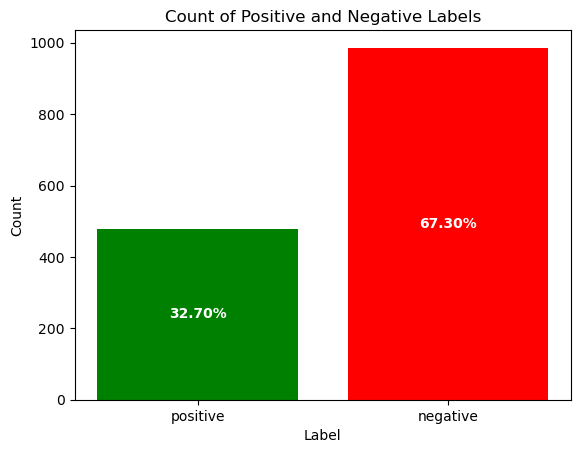

In [36]:
label_counts = dataMK['label'].value_counts()[['positive', 'negative']]
total = len(dataMK)
percentages = (label_counts / total * 100).round(2)

plt.bar(label_counts.index, label_counts.values, color=['green', 'red'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Labels')

for i, count in enumerate(label_counts.values):
  percentage = percentages[i]
  plt.text(i, count / 2, f'{percentage:.2f}%', ha='center', va='center', 
           color='white', weight='bold')

plt.show()

### Probability Distribution

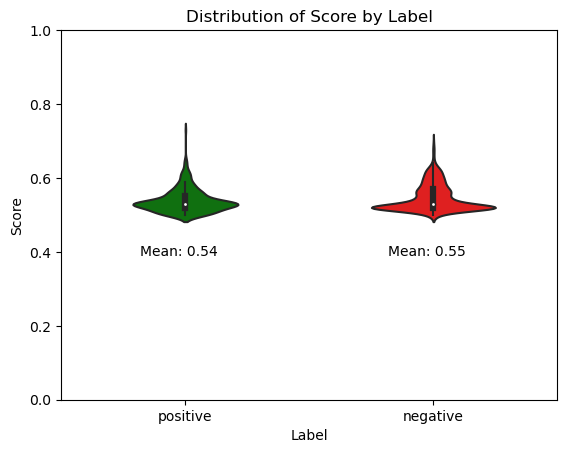

In [40]:
import seaborn as sns
import numpy as np

sns.violinplot(x='label', y='score', data=dataMK, 
               palette={'positive': 'green', 'negative': 'red'},
               width=0.5)
plt.xlabel('Label')
plt.ylabel('Score')
plt.title('Distribution of Score by Label')
plt.ylim(0,1)

# Calculate mean for positive and negative
mean_positive = np.mean(dataMK[dataMK['label'] == 'positive']['score'])
mean_negative = np.mean(dataMK[dataMK['label'] == 'negative']['score'])

# Add annotations
plt.text(-0.025, 0.4, f'Mean: {mean_positive:.2f}', ha='center', va='center')
plt.text(0.975, 0.4, f'Mean: {mean_negative:.2f}', ha='center', va='center')

plt.show()

### Word Frequencies

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(dataMK['stemmed_text'])

In [44]:
term_frequencies = np.sum(dtm, axis=0)
terms = vectorizer.get_feature_names_out()
sorted_indices = np.argsort(term_frequencies)[0, ::-1]

top_terms_with_frequencies = [(terms[i], term_frequencies[0, i]) for i in sorted_indices[0, :10]]

for term, frequency in top_terms_with_frequencies:
  print(term, frequency)

[['bukan' 'tunda' 'batal' 'kembali' 'mahasiswa' 'teman' 'jangan' 'rakyat'
  'hari' 'sampai']] [[660 634 580 254 213 190 146 146 144 140]]


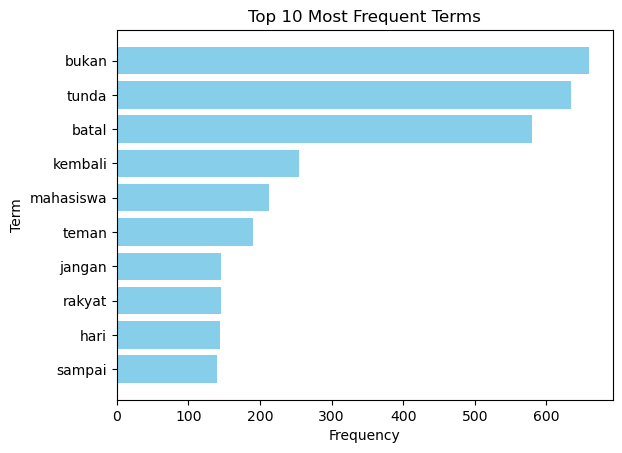

In [45]:
terms = ['bukan', 'tunda', 'batal', 'kembali', 'mahasiswa', 'teman', 'jangan', 'rakyat', 'hari', 'sampai']
frequencies = np.array([660, 634, 580, 254, 213, 190, 146, 146, 144, 140])

plt.barh(terms, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Term')
plt.title('Top 10 Most Frequent Terms')
plt.gca().invert_yaxis() 
plt.show()

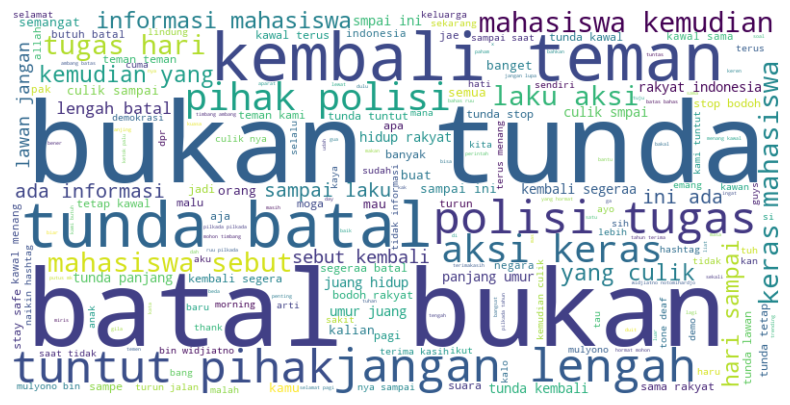

In [42]:
# Gabungkan semua unigrams menjadi satu string
unigram_stem_text = ' '.join(dataMK['stemmed_text'])

wordcloud_unigram_stem = WordCloud(width=800, height=400, background_color='white').generate(unigram_stem_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_unigram_stem, interpolation='bilinear')
plt.axis('off')
plt.show()

### TF-IDF Word Analysis

In [49]:
dataMK.reset_index(drop=True, inplace=True)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = dataMK["stemmed_text"]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit the vectorizer to the text data
tfidf = vectorizer.fit_transform(text_data)

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

# Calculate IDF weights for each term
idf_weights = vectorizer.idf_

# Function to calculate sentiment-weighted TF-IDF score
def sentiment_weighted_tfidf(term_index, sentiment_scores):
  term_indices = tfidf[:, term_index].nonzero()[0]  # Get indices of documents containing the term

  # Avoid division by zero (if no documents contain the term)
  if len(term_indices) == 0:
    return 0

  # Calculate average sentiment for documents containing the term
  average_sentiment = np.mean(sentiment_scores[term_indices])

  # Calculate TF-IDF score weighted by average sentiment
  return tfidf[:, term_index].mean() * average_sentiment

# Calculate sentiment-weighted TF-IDF scores for all terms
tfidf_scores = []
for i in range(len(terms)):
  tfidf_scores.append(sentiment_weighted_tfidf(i, dataMK["score"]))

# Sort terms and scores by sentiment-weighted TF-IDF (descending order)
sorted_indices = np.argsort(tfidf_scores)[::-1]

# Print top 10 topics with their sentiment-weighted TF-IDF scores
print("Top 10 Topics (Sentiment-Weighted TF-IDF):")
for i in range(10):
  term = terms[sorted_indices[i]]
  score = tfidf_scores[sorted_indices[i]]
  print(f"{term}: {score:.4f}")

Top 10 Topics (Sentiment-Weighted TF-IDF):
tunda: 0.0965
bukan: 0.0961
batal: 0.0939
teman: 0.0350
kembali: 0.0340
mahasiswa: 0.0170
jangan: 0.0160
kawal: 0.0158
rakyat: 0.0142
lengah: 0.0141


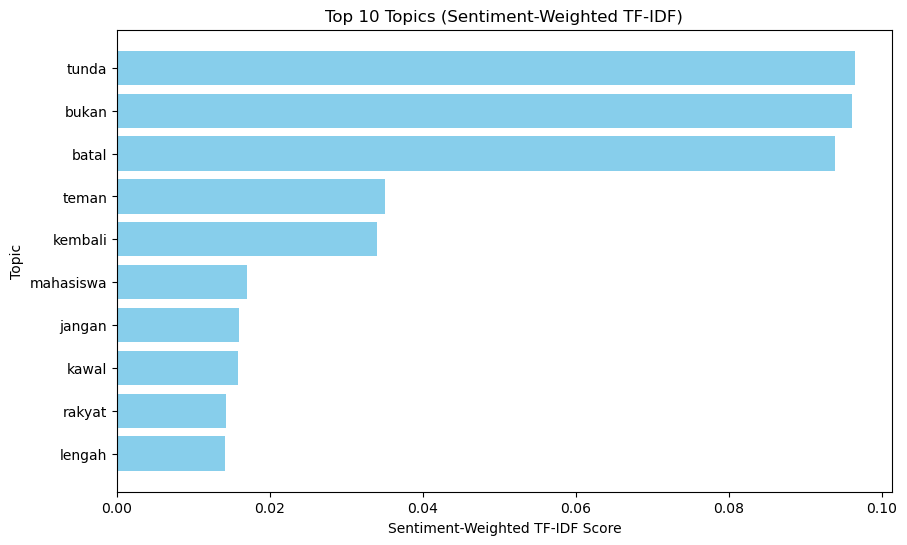

In [76]:
import matplotlib.pyplot as plt

topics = ["tunda", "bukan", "batal", "teman", "kembali", "mahasiswa", "jangan", "kawal", "rakyat", "lengah"]
scores = [0.0965, 0.0961, 0.0939, 0.0350, 0.0340, 0.0170, 0.0160, 0.0158, 0.0142, 0.0141]

plt.figure(figsize=(10, 6))
plt.barh(topics, scores, color='skyblue')
plt.xlabel("Sentiment-Weighted TF-IDF Score")
plt.ylabel("Topic")
plt.title("Top 10 Topics (Sentiment-Weighted TF-IDF)")
plt.gca().invert_yaxis()
plt.show()

### LDA Topic Analysis

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Create a CountVectorizer to convert text to a document-term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataMK['stemmed_text'])

# Create an LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed

# Fit the LDA model to the document-term matrix
lda.fit(X)

# Get the topic-word distribution
topic_word_distribution = lda.components_

# Print the top 10 words for each topic
num_top_words = 10
for topic_idx, topic in enumerate(topic_word_distribution):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

Topic 1:
stay safe hari semangat semua jangan turun moga buat naikin
Topic 2:
mahasiswa sampai polisi kembali hari laku culik tugas aksi pihak
Topic 3:
bukan tunda batal teman kembali jangan rakyat lengah kawal lawan
Topic 4:
banget banyak pilkada sampe pagi malu kasih kamu yang artis
Topic 5:
mau rakyat apa kalian orang kamu buat banget jadi pak


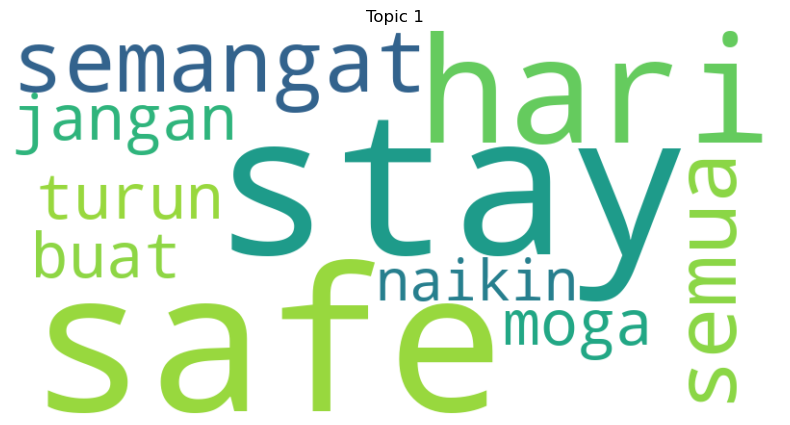

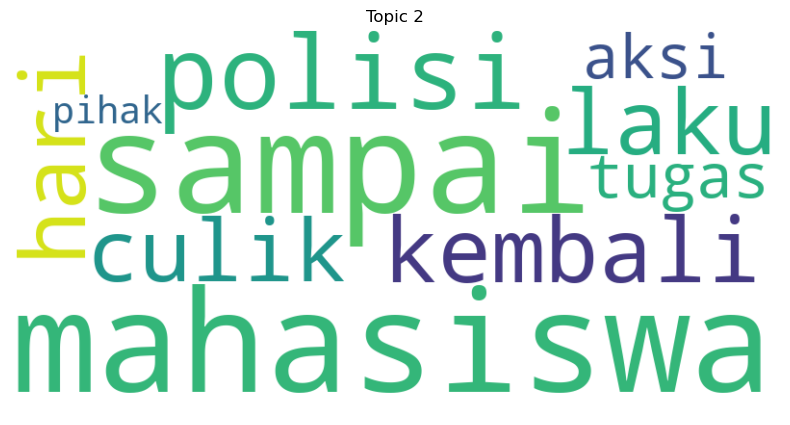

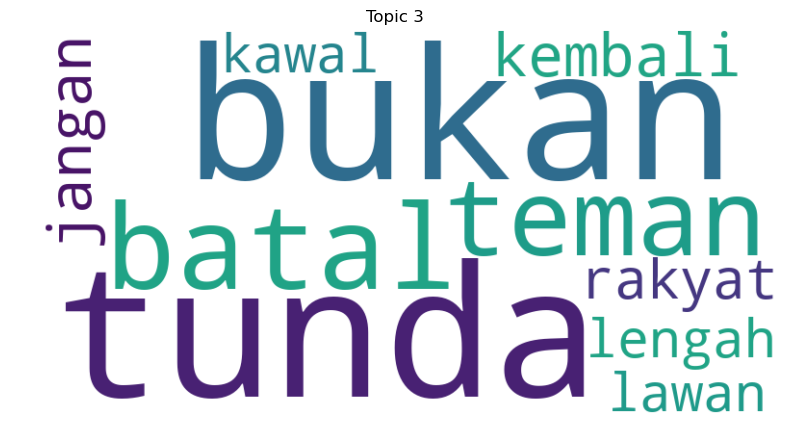

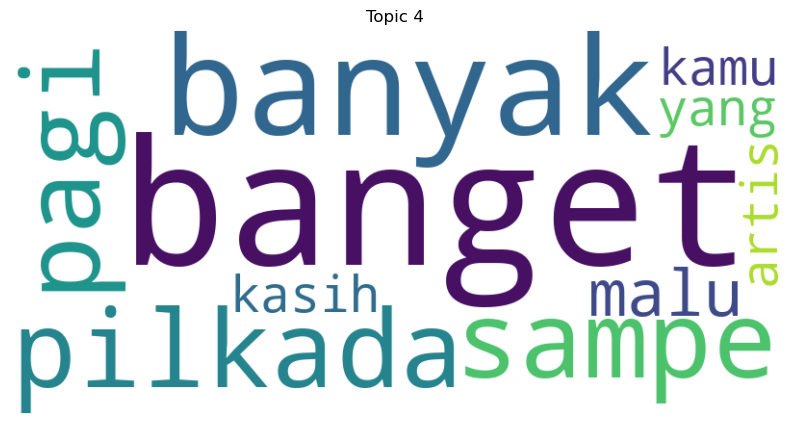

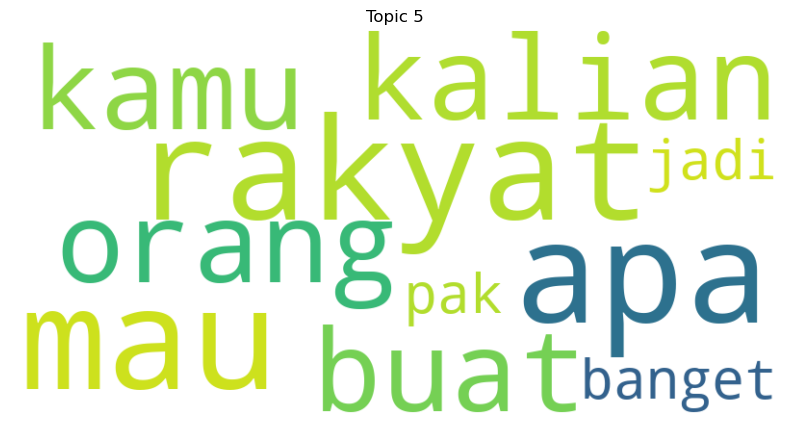

In [75]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for topic_idx, topic in enumerate(topic_word_distribution):
    topic_words = vectorizer.get_feature_names_out()[topic.argsort()[:-num_top_words - 1:-1]]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic_words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()